In [11]:
import numpy as np
from My_custom_Envs import HangedManEnv
import statsmodels
import random
max_length = 3

# TP 4 Optimiser le model Q-learning. 

### 1. Amélioration de la strategy Epsilon-greedy

Mettre à jour la valeur du paramètre epsilon pour diminuer l'apprentissage au fure à à mesure de l'appprentissage pour réduire l'apprentissage. 


- __Decay Epsilon__ : Intitivement on chercher à avoir plus d'exploration au début et moins au fure et à mesure que l'on avance dans l'exploration. 
__Epsilon decay est utilisé pour progressivement réduire l'exploration au fur et à mesure que l'agent apprend.__
Un facteur de 0.995 à 0.999 est souvent utilisé pour réduire epsilon à chaque épisode, voici quelque exemples. 
    - 0.995 : Le taux de décroissance fait en sorte qu'il faut environ 1000 épisodes pour que l'epsilon passe de 1 à environ 0.006.
    - 0.99 : Plus rapide, epsilon se rapproche de 0 plus rapidement, ce qui signifie moins d'exploration après quelques centaines d'épisodes.
    - 0.999 : Une décroissance plus lente permet à l'agent d'explorer plus longtemps.

- __Min_Epsilon__: Quand on utilise un epsilon decay, il faut être assuré de garder une approximation, 0.05 pour l'epsilon minimum est petit pour il est gros. 
Make sure your minimum epsilon value min_epsilon = 0.05 is appropriate. Lower values (e.g., min_epsilon = 0.01) allow more exploitation after learning stabilizes.



### 2. Jouer avec la valeur initiale de la Q-table

La Q-Table représente les estimations des valeurs d'état-action (Q(s, a)). 

Lors de l'initialisation, vous devez affecter une valeur à chaque paire état-action. 

Cette valeur influence les premières décisions de l'agent et peut avoir un impact sur la rapidité avec laquelle l'agent découvre une politique optimale.

Si vous êtes dans un environnement où l'exploration est essentielle, un **optimisme initial** peut aider à accélérer l'apprentissage. Cependant, dans des environnements où les récompenses sont déjà bien équilibrées, commencer avec une Q-Table initialisée à zéro est souvent un bon choix.

__Cas typiques d'initialisation :__

- __Valeur faible (souvent 0)__ : L'agent part du principe qu'il n'y a aucune récompense au début, et il devra apprendre les récompenses en explorant.
- __Valeur élevée__ : L'agent part du principe que chaque action pourrait rapporter beaucoup de récompenses. Cela encourage initialement l'exploration, car il essaiera chaque action pour découvrir si elle est vraiment bonne ou non.

|Initialisation            | Avantage	| Inconvénient  |
|--------------------------|----------|----------------------------|
|Valeur nulle (0)	       |Simple et généralement efficace, surtout si les récompenses sont faibles ou nulles la plupart du temps.  |	Peut ralentir l'apprentissage si certaines actions doivent être explorées plus tôt.  |	
|	Valeur positive (optimiste)	| Encourage l'exploration initiale, car l'agent "pense" que chaque action est bonne. Cela peut aider à découvrir des stratégies gagnantes plus rapidement.	| Risque d'exploration trop importante. L'agent peut passer beaucoup de temps à explorer des actions qui ne sont pas optimales. |
| Valeur négative |	Encourage l'agent à éviter les actions jusqu'à ce qu'il ait trouvé des informations positives sur elles.  Peut être utile si certaines actions sont généralement mauvaises.	| Peut décourager l'exploration si certaines actions sont sous-estimées au départ.|

# Correction 

In [10]:
def epsilon_greedy_policy(state,q_table,epsilon= 0.3):
    """
    Returns an action based on epsilon-greedy policy.
    """
    if np.random.uniform(0, 1) < epsilon:
        # Exploration : Choisi une action aléatoire parmi les actionns possibl
        active_actions = np.where((1 - state[1]))[0]
        return random.choice(active_actions)
    else:
        
        # Exploitation: Choisir l'action avec la Q-value maximale pour l'état courant
        # Selection la ligne qui corresponds à l'état courant
        masked_q_values = np.copy(q_table[state[0]])    
        
        # Masque les actions interdites en utilisant le second éléments de l'entrée ( les lettres déjà jouées) , si il y a des actions interdites. 
        if sum( state[1] ) > 0 : masked_q_values[state[1]] = -np.inf  
       
        # renvoi l'action qui corresponds à la Q-value maximale 
        return np.argmax(masked_q_values)  

Commençons l'apprentissage 

In [9]:
## Les mesures que l'on va garder par épisode 
n_episode = 50000

hist_reward = np.zeros(n_episode)         # les rewards obtenu par épisodes 
hist_actions = np.zeros((26, n_episode))  # l'ordre les lettres choisies ( dictionnaire de liste)

# Parameters influencing learning performance 
epsilon_decay = 0.9975
min_epsilon = 0.05

init_value_qtable = 0.3 
epsilon = 0.3
discount_factor = 1
learning_rate = 0.1

# Initialisation de la Q-table
q_table = np.full(( 28**max_length, 26), init_value_qtable, dtype=float)  # 32 états possibles et 26 actions (lettres)
                        # max_length correspond HangedManEnv.max_word_size , by default 8 
env = HangedManEnv(max_word_size=max_length)
# Initialisation de l'environnement

for episode in range(n_episode):
    
    # Restart episode
    obs, info = env.reset()
    terminated = False
    step = 1
    ## Convert observation to state  for indexing in Q-table
    state_index = np.dot(obs[0], [28**i for i in range(max_length)])

    while not terminated: 
            
        ## Choisie l'actio
        action = epsilon_greedy_policy( state=( state_index, obs[1]), epsilon=epsilon, q_table=q_table)   # obs[1] : contient les lettres restantes à jouer
        
        ## Jouer l'action choisie
        obs , reward, terminated, _, _  =env.step( action )  

        ### Mise à jours de la Q_table

        # Convertir le state en index 
        next_state_index = np.dot(obs[0], [28**i for i in range(max_length)])

        best_next_action = np.argmax(q_table[next_state_index])
        td_target = reward + discount_factor * q_table[next_state_index][best_next_action]
        td_error = td_target - q_table[state_index][action]
        q_table[state_index][action] += learning_rate * td_error

        state_index = next_state_index
        epsilon *= epsilon_decay
        epsilon = max(epsilon, min_epsilon)


        ##  Sauve des données d'entrainement pour analyser
        hist_actions[ action, episode ] = step
        hist_reward[episode] = hist_reward[episode] + reward
        step = step + 1 

env.close()

In [82]:
window_size = 500
moving_avg_rewards = np.convolve(hist_reward, np.ones(window_size)/window_size, mode='valid')


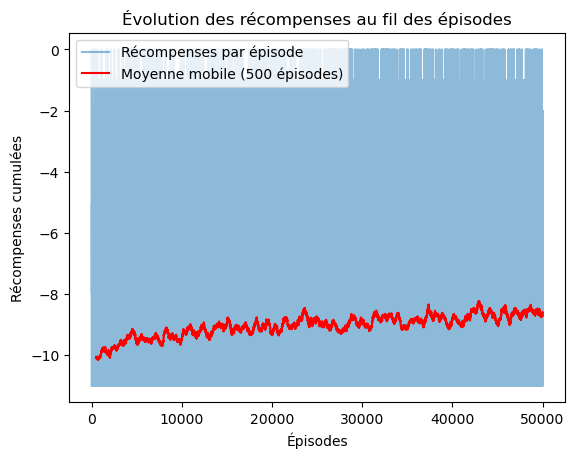

In [83]:
import matplotlib.pyplot as plt
# Tracer l'évolution des récompenses par épisode
plt.plot(range(n_episode), hist_reward, label='Récompenses par épisode', alpha=0.5)
plt.plot(range(window_size-1, n_episode), moving_avg_rewards, label=f'Moyenne mobile ({window_size} épisodes)', color='red')
# Ajouter un titre et des labels
plt.title("Évolution des récompenses au fil des épisodes")
plt.xlabel("Épisodes")
plt.ylabel("Récompenses cumulées")

# Afficher la légende et le graphique
plt.legend()
plt.show()

In [84]:
n_victories = sum(hist_reward > -11 )

In [85]:
# Calcul de la probabilité de gagner
probability_of_winning = n_victories / n_episode
print(f"Probabilité de gagner après {n_episode} parties : {probability_of_winning:.2f}")


from statsmodels.stats.proportion import proportion_confint
confidence_level = 0.95  # Intervalle de confiance à 95%


# Calculer l'intervalle de confiance avec l'approximation normale (méthode 'normal')
lower_bound, upper_bound = proportion_confint(n_victories, n_episode, alpha=1-confidence_level, method='normal')

print(f"Proportion observée : {probability_of_winning:.4f}")
print(f"Intervalle de confiance à 95% : [{lower_bound:.4f}, {upper_bound:.4f}]")

Probabilité de gagner après 50000 parties : 0.39
Proportion observée : 0.3852
Intervalle de confiance à 95% : [0.3810, 0.3895]



​
